# Notebook: SAM (segment anything) on CamVid

このノートブックでは、CamVidデータセットを使って、Hugging faceにあるSegment anything model ([SAM](https://huggingface.co/docs/transformers/main/en/model_doc/sam))を使ったセグメンテーションを試します

ノートブック作成にあたり、下記を参考にさせて頂きました🤗

- https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb

- https://github.com/huggingface/notebooks/blob/main/examples/segment_anything.ipynb

- https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SAM/Fine_tune_SAM_(segment_anything)_on_a_custom_dataset.ipynb

## CamVidデータセットとは

[CamVid](https://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/)データセットは、イギリス・ケンブリッジで撮影されたビデオデータを含むコレクションであり、以下の特性を持ちます

- セマンティックセグメンテーション: 各ピクセルが32のセマンティッククラスのいずれかに関連付けられています。これは物体のクラス分類だけでなく、ピクセル単位での正解ラベルが提供されていることを意味します

- 車からの視点: 通常の固定位置のカメラではなく、車から見た視点での映像が含まれています。これにより、移動中の状況でのオブジェクトの観察が可能になります

- 画像サイズ: すべての画像は320x480のサイズで統一されています

- ground truth labels: 各ピクセルに対して正解ラベルが提供されており、ピクセルがどのクラスに属するかが明確になっています

- 30Hzの映像: 高品質で30Hzの映像が提供されており、それに対応するセマンティックラベル画像が1Hzおよび一部15Hzで提供されています

## セットアップ

- fine-tuneしたモデルを保存するgoogle driveをマウントします

- Hugging faceのモジュール(Transformers, Datasets)をインストールします

- カスタムなロス関数を使うため[Monai](https://github.com/Project-MONAI/MONAI)をインストールします

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets
!pip install -q monai

Mounted at /content/drive
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.8 MB/s eta 0:00:00


## データセットのロード
[Camvid](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.) データセットをダウンロードします

Camvidのデータセットを評価用に使いやすく加工されたものが、[こちらのgithubリポジトリ](https://github.com/alexgkendall/SegNet-Tutorial/tree/master/CamVid)に保存されているので `git clone` を実行して取得します

データセットの構成は以下となります
- 入力データとなる車両から撮影したカメラ画像
- 正解データとなるmaskデータは、オブジェクトクラス毎にセマンティックセグメンテーションされている
- 学習、評価、テスト用のデータに別々に用意
- 全ての画像サイズは320x480

In [3]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

DATA_DIR = './data/CamVid/'

CLASSES = ['sky', 'building', 'pole', 'road', 'pavement',
            'tree', 'signsymbol', 'fence', 'car',
            'pedestrian', 'bicyclist', 'unlabelled']

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./orig_data')

## 前処理(画像のリサイズ)
学習効率向上の為、画像を256x256へリサイズします

リサイズした画像は別ディレクトリに保存します

maskデータも同様にリサイズしますが、今回は`car`のみセグメンテーションされた画像が必要なので、`car`の領域は1、`car`以外の領域は0になるように加工します

In [4]:
from tqdm import tqdm
import pandas as pd

input_dir = './orig_data/CamVid'
output_dir = './data/CamVid'

base_dirs = ["train", "val", "test"]
for base_dir in base_dirs:
    # 出力ディレクトリ作成
    os.makedirs(os.path.join(output_dir, base_dir), exist_ok=True)
    os.makedirs(os.path.join(output_dir, f"{base_dir}annot"), exist_ok=True)

    # 画像ファイルのリストを取得
    image_files = [f for f in os.listdir(os.path.join(input_dir, base_dir)) if f.endswith(('.png'))]
    #image_files = image_files[:12]

    size_list = []
    for image_file in tqdm(image_files, desc = base_dir):
        # オリジナル画像の読み込み
        original_image = cv2.imread(os.path.join(input_dir, base_dir, image_file))

        # オリジナル画像のサイズを取得
        original_height, original_width = original_image.shape[:2]

        # リサイズ
        image = cv2.resize(original_image, (256, 256))

        # マスク画像の読み込み
        original_mask = cv2.imread(os.path.join(input_dir, f"{base_dir}annot", image_file), 0)
        original_mask = np.array(original_mask)

        # リサイズ時のマスク値の処理
        label = CLASSES.index("car")
        mask = np.zeros(original_mask.shape)
        mask[original_mask == label] = 255

        # リサイズ
        mask = cv2.resize(mask, (256, 256))
        mask[mask > 0] = label
        if not np.sum(mask > 0):    # labelに該当するセグメントが画像内になければ保存しない
            continue

        mask = mask.astype(np.uint8)

        # 元のフォーマットに変換（カラー）
        mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

        # オリジナル画像のサイズを保存
        size_list.append({"file_name": image_file, "height": original_height, "width": original_width})

        # 画像を保存する
        cv2.imwrite(os.path.join(output_dir, base_dir, image_file), image)

        # マスク画像を保存する
        cv2.imwrite(os.path.join(output_dir, f"{base_dir}annot", image_file), mask)

    pd.DataFrame(size_list, columns=["filename", "height", "width"])\
        .to_csv(os.path.join(output_dir, f"original_size_list_{base_dir}.csv"), index=False)

test: 100%|██████████| 233/233 [00:08<00:00, 26.14it/s]


リサイズされた画像が正しく処理されているか目視で確認します

リサイズ値の補正により、mask値がぼやける・飛び飛びになるといった不具合が生じる場合があります

**目視確認はとても大事な工程です**

これを飛ばして「不正な正解データで学習していた」と学習後に気づいてしまうと、学習のやり直しによる時間的なロスだったり、報告後・納品後に気づいてしまい信用問題になる等、後々大変なことになる可能性があるので、面倒でも必ず行うようにしましょう

In [6]:
def get_bounding_box(ground_truth_map):
    # get bounding box from mask
    indices = np.where(ground_truth_map > 0)
    if not len(indices[0]):
        raise ValueError("bounding box doesn't exist")
    y_indices, x_indices = indices
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox

train:   0%|          | 0/360 [00:00<?, ?it/s]

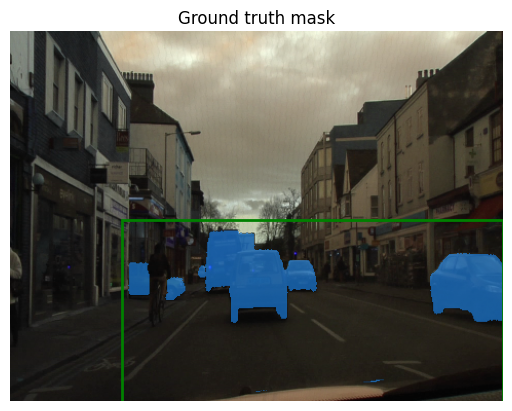

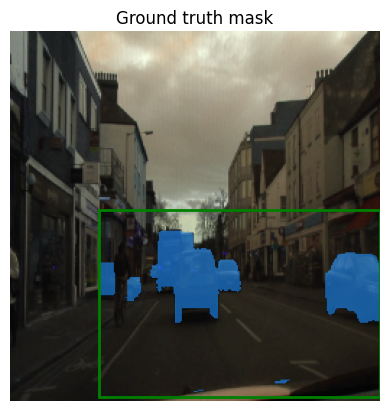

val:   0%|          | 0/101 [00:00<?, ?it/s]

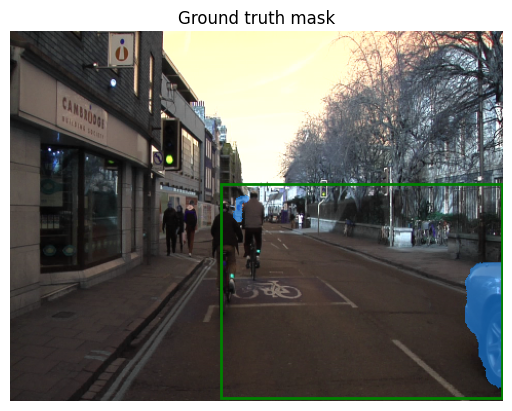

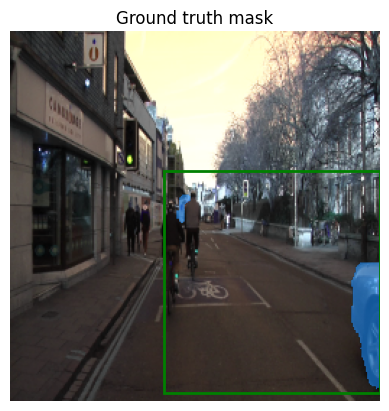

test:   0%|          | 0/223 [00:00<?, ?it/s]

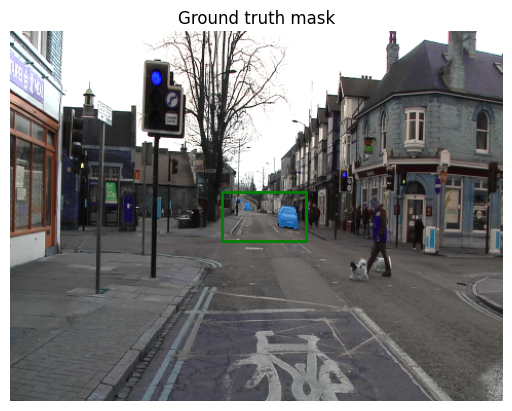

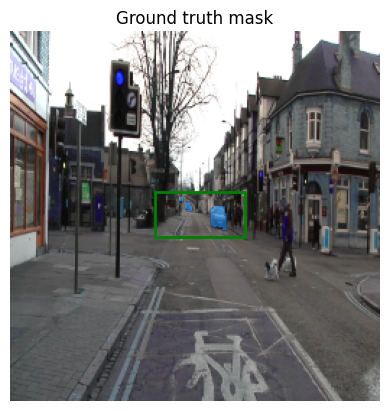

test:   0%|          | 0/223 [00:00<?, ?it/s]


In [7]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

orig_input_dir = "./orig_data/CamVid"
resized_input_dir = './data/CamVid'

base_dirs = ["train", "val", "test"]
for base_dir in base_dirs:
    # 画像ファイルのリストを取得
    image_files = [f for f in os.listdir(os.path.join(resized_input_dir, base_dir)) if f.endswith(('.png'))]

    for image_file in tqdm(image_files, desc = base_dir):
        size_list = []
        for input_dir in [orig_input_dir, resized_input_dir]:
            # オリジナル画像の読み込み
            image = cv2.imread(os.path.join(input_dir, base_dir, image_file))
            mask = cv2.imread(os.path.join(input_dir, f"{base_dir}annot", image_file), 0)

            # extract certain classes from mask (e.g. cars)
            masks = [(mask == v) for v in [CLASSES.index("car")]]
            mask = np.stack(masks, axis=-1).astype('float')
            if not len(mask):
                mask = np.zeros(image.shape[:2])

            mask = mask.reshape((mask.shape[0], mask.shape[1]))

            # get bounding box prompt
            prompt = get_bounding_box(mask)

            # save image with prompt
            fig, axes = plt.subplots()

            axes.imshow(np.array(image))
            ground_truth_seg = np.array(mask.squeeze())
            show_mask(ground_truth_seg, axes)

            show_box(prompt, plt.gca())

            axes.title.set_text(f"Ground truth mask")
            axes.axis("off")
            plt.show()
        break

リサイズされた画像のmask値は正しく処理され、bounding boxも学習には問題なく適用されているようです

## PyTorch datasetの作成

PyTorch datasetのカスタムクラスを作ります

`__getitem__` により呼び出されたinputデータは下記を含んでいます

* `pixel values` (モデルのために前処理加工された画像):
処理内容は [SamImageProcessorのパラメータ](https://huggingface.co/docs/transformers/v4.33.3/en/model_doc/mobilevit#transformers.SamImageProcessor)で指定します
(今回はデフォルトの値を使用)。
* `input_boxes`: 正解となるセグメンテーションマスク値を`get_bounding_box` の引数に与えることで得られる、bounding boxのプロンプト
* `ground_truth_mask`: 正解のセグメンテーションマスク


In [6]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        processor (transformers.SamProcessor): SAM processor
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement',
               'tree', 'signsymbol', 'fence', 'car',
               'pedestrian', 'bicyclist', 'unlabelled']

    def __init__(
            self,
            images_dir,
            masks_dir,
            processor,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        self.processor = processor

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        if not len(mask):
            mask = np.zeros(image.shape[:2])

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        mask = mask.reshape((mask.shape[0], mask.shape[1]))

        # get bounding box prompt
        prompt = get_bounding_box(mask)

        # prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}

        # add ground truth segmentation
        inputs["ground_truth_mask"] = mask

        # add original image
        inputs["raw_image"] = image

        # add image_id
        inputs["image_id"] = self.ids[i]

        return inputs

    def __len__(self):
        return len(self.ids)

## SamProcessorの読み込み
SamModelのProcessorを読み込みます

今回はsam-vit-baseを使用します

In [7]:
from transformers import SamProcessor

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

#processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

train_dataset = Dataset(x_train_dir, y_train_dir, processor, classes=['car'])
valid_dataset = Dataset(x_valid_dir, y_valid_dir, processor, classes=['car'])
test_dataset = Dataset(x_test_dir, y_test_dir, processor, classes=['car'])

## PyTorch DataLoaderの作成

先に作成したPyTorch Datasetを元にDataLoaderを作成します


In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

for batch in train_dataloader:
    for k, v in batch.items():
        print (k, np.array(v).shape)
    break

pixel_values (4, 3, 1024, 1024)
original_sizes (4, 2)
reshaped_input_sizes (4, 2)
input_boxes (4, 1, 4)
ground_truth_mask (4, 256, 256)
raw_image (4, 256, 256, 3)
image_id (4,)


## SamModelの読み込み

SamModelの基盤モデルを読み込みます

今回はsam-vit-baseを使用します

In [9]:
from transformers import SamModel

#model = SamModel.from_pretrained("facebook/sam-vit-huge")
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

## モデル学習

In [10]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [11]:
import time
import pandas as pd
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 100

device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# 学習結果を保存する
save_dir = "/content/drive/MyDrive/colab"   # 所望の場所に変更して下さい
losses_path = f"{save_dir}/loss_ft_sam_camvid-base.csv"
columns = ["epoch", "loss_train", "loss_eval"]
df_loss = pd.DataFrame([], columns=columns)
start_epoch = 0
best_loss = np.inf

# 途中から学習を再開する場合、保存したチェックポイントを読み込む
save_path = f"{save_dir}/fine_tune_sam_camvid-base.pth"
if os.path.exists(save_path):
    if device == "cpu":
        checkpoint = torch.load(save_path, map_location=torch.device("cpu"))
    else:
        checkpoint = torch.load(save_path)
    model.load_state_dict(checkpoint)

    df_loss = pd.read_csv(losses_path)
    start_epoch = df_loss["epoch"].values[-1] + 1
    best_loss = df_loss["loss_eval"].values[-1]

for epoch in range(start_epoch, num_epochs):
    print(f'## EPOCH: {epoch} best_loss_eval: {best_loss}')

    # 学習フェーズ
    model.train()
    epoch_losses = []

    times = []
    iter_train_dataloader = iter(train_dataloader)
    idx = 0

    print (f"train data {len(train_dataloader)}...")
    for batch in tqdm(train_dataloader):
        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())
    loss_train = mean(epoch_losses)
    print(f'Mean loss (train): {loss_train}')

    # 評価フェーズ
    model.eval()
    with torch.no_grad():
        epoch_losses = []

        print (f"valid data {len(valid_dataloader)}...")
        for batch in tqdm(valid_dataloader):
            # forward pass
            outputs = model(pixel_values=batch["pixel_values"].to(device),
                            input_boxes=batch["input_boxes"].to(device),
                            multimask_output=False)

            # compute loss
            predicted_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

            epoch_losses.append(loss.item())

        loss_eval = mean(epoch_losses)
        print(f'Mean loss (valid): {loss_eval}')

        # 学習結果保存
        result = {
            "epoch": epoch,
            "loss_train": loss_train,
            "loss_eval": loss_eval
        }
        df_loss = pd.concat([df_loss, pd.DataFrame([result])], axis=0)
        df_loss.to_csv(losses_path, index=False)

        # 評価値更新
        if mean(epoch_losses) < best_loss:
            best_loss = mean(epoch_losses)
            torch.save(model.state_dict(), save_path)
            print("Model saved!")

## 学習結果の可視化

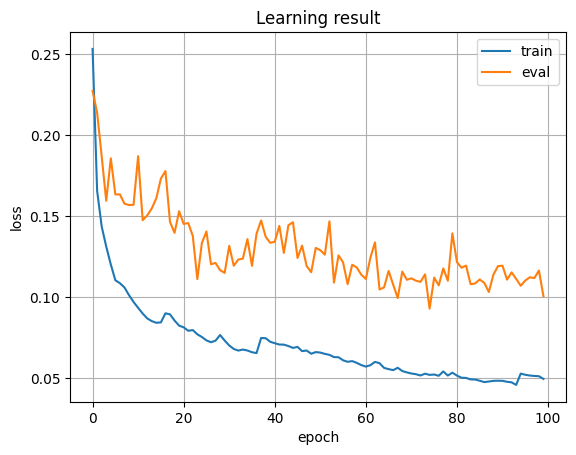

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df_loss["epoch"], df_loss["loss_train"], label="train")
plt.plot(df_loss["epoch"], df_loss["loss_eval"], label="eval")
plt.title("Learning result")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(True)
plt.legend(loc="best")
plt.show()

lossカーブの変動は有りますがEpoch毎に徐々に下がってきており、学習は上手くいっているようです

終わりの100 epoch時点でも傾きは下り傾向だったので、Epoch数を更に増やせばより改善が見込めると思います

## 推定結果

まずは学習に使用したデータを使い、学習が正しく行われたか確認します

入力プロンプトであるbounding box、予測マスク値、正解マスク値を確認します



(-0.5, 255.5, 255.5, -0.5)

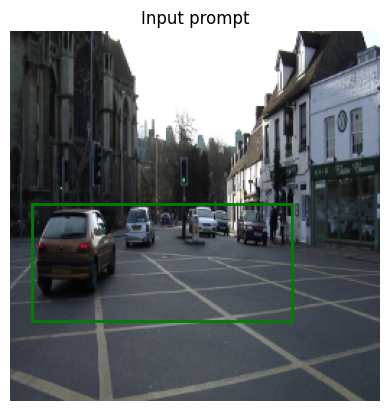

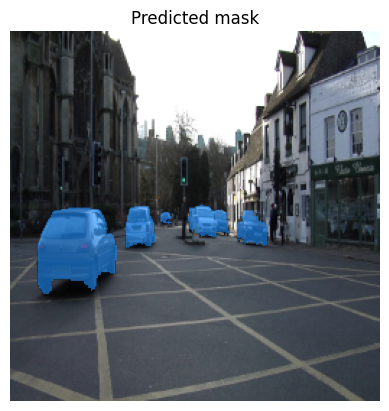

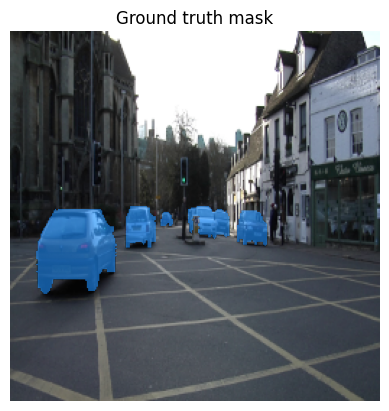

In [13]:
# 評価用に乱数を固定する
seed = 42
torch.manual_seed(seed)

# GPUを使う場合には以下のコードも追加
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

inputs = train_dataset[10]

image=inputs["raw_image"]
mask=inputs["ground_truth_mask"].squeeze()

inputs = processor(image, return_tensors="pt").to(device)
image_embeddings = model.get_image_embeddings(inputs["pixel_values"])

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_boxes_on_image(raw_image, boxes):
    plt.figure()
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.title("Input prompt")
    plt.axis('off')

# get box prompt based on ground truth segmentation map
prompt = get_bounding_box(np.array(mask))

# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
# pop the pixel_values as they are not neded
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

show_boxes_on_image(image, [prompt])

model.eval()

# forward pass
with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)

# apply sigmoid
sam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
sam_seg_prob = sam_seg_prob.cpu().numpy().squeeze()
sam_seg = (sam_seg_prob > 0.5).astype(np.uint8)

fig, axes = plt.subplots()
axes.imshow(np.array(image))
show_mask(sam_seg, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

fig, axes = plt.subplots()
axes.imshow(np.array(image))
ground_truth_seg = np.array(mask)
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

上記結果を元にIoUを計算します

In [14]:
import numpy as np

def calculate_iou(segmentation1, segmentation2):
    intersection = np.logical_and(segmentation1, segmentation2)
    union = np.logical_or(segmentation1, segmentation2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

# IoUを計算
iou_score = calculate_iou(sam_seg.astype(bool), ground_truth_seg.astype(bool))
print(f"IoU: {iou_score}")

IoU: 0.9080404429465575


IoUが90%程度となり、学習が正しく実行されたことが確認できました

次に使用したデータ全てのIoUを計算し、学習、評価、テストデータのIoU平均値をそれぞれ確認します

In [15]:
# 評価用に乱数を固定する
seed = 42
torch.manual_seed(seed)

# GPUを使う場合には以下のコードも追加
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

labels = ["train", "valid", "test"]
datasets = [train_dataset, valid_dataset, test_dataset]
iou_scores_dict = {label: [] for label in labels}

iou_scores_path = "{save_dir}/iou_scores_{label}_ft_sam_camvid-base.csv"
for label, dataset in zip(labels, datasets):
    if os.path.exists(iou_scores_path.format(save_dir = save_dir, label = label)):
        continue

    print (f"###  {label}")
    for idx, inputs in tqdm(enumerate(dataset), desc=f"{label} data {len(dataset)}"):
        image_id = inputs["image_id"]
        image=inputs["raw_image"]
        mask=inputs["ground_truth_mask"].squeeze()

        # get box prompt based on ground truth segmentation map
        prompt = get_bounding_box(np.array(mask))

        # prepare image + box prompt for the model
        inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)

        model.eval()

        # forward pass
        with torch.no_grad():
            outputs = model(**inputs, multimask_output=False)

        # apply sigmoid
        sam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
        # convert soft mask to hard mask
        sam_seg_prob = sam_seg_prob.cpu().numpy().squeeze()
        sam_seg = (sam_seg_prob > 0.5).astype(np.uint8)

        ground_truth_seg = np.array(mask)

        iou_score = calculate_iou(sam_seg.astype(bool), ground_truth_seg.astype(bool))
        iou_scores_dict[label].append([image_id, iou_score])
    print (f"mean: {np.nanmean(np.array(iou_scores_dict[label])[:,1].astype(float), axis=0)}")
    print (f"std: {np.nanstd(np.array(iou_scores_dict[label])[:,1].astype(float), axis=0)}")

    data = np.array(iou_scores_dict[label])
    pd.DataFrame(data).to_csv(iou_scores_path.format(save_dir = save_dir, label = label), header=None, index=False)

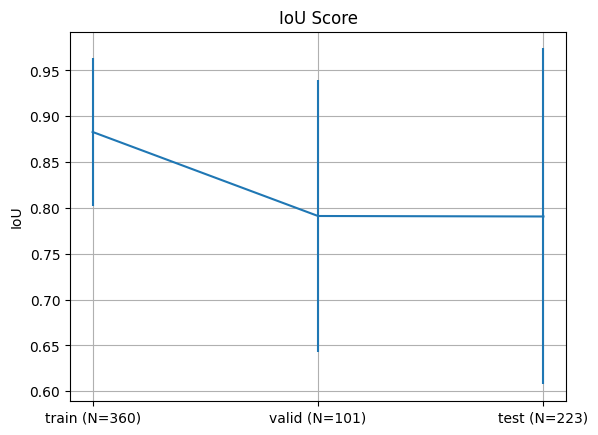

In [16]:
means = []
stds = []
nums = []
for label in labels:
    df = pd.read_csv(iou_scores_path.format(save_dir = save_dir, label = label), header=None)
    means.append(df.values[:,1].mean())
    stds.append(df.values[:,1].std())
    nums.append(df.values[:,1].size)

plt.figure()
plt.errorbar(np.arange(len(labels)), means, yerr=stds)
plt.xticks(np.arange(len(labels)), [f"{label} (N={num})" for label, num in zip(labels, nums)])
plt.ylabel("IoU")
plt.title("IoU Score")
plt.grid(True)

学習データは90%程度、評価とテストデータでは80%程度と中々の高精度となりました

最高と最低のIoUスコアとなった画像を出力して、入力画像の特徴や傾向を目視確認して精度への影響を確認します

In [18]:
# 評価用に乱数を固定する
seed = 42
torch.manual_seed(seed)

# GPUを使う場合には以下のコードも追加
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

from collections import Counter

for label, dataset in zip(labels, datasets):
    df = pd.read_csv(iou_scores_path.format(save_dir = save_dir, label = label), header=None)
    image_ids = df.values[:,0]
    iou_scores = df.values[:,1]

    max_score_idx = np.argmax(iou_scores)
    min_score_idx = np.argmin(iou_scores)

    ds_dict = {inputs["image_id"]: inputs for inputs in dataset}
    for score_idx in [max_score_idx, min_score_idx]:
        iou_score = iou_scores[score_idx]
        image_id = image_ids[score_idx]

        inputs = ds_dict[image_id]
        image=inputs["raw_image"]
        mask=inputs["ground_truth_mask"].squeeze()

        # get box prompt based on ground truth segmentation map
        prompt = get_bounding_box(np.array(mask))

        # prepare image + box prompt for the model
        inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)

        plt.figure()
        plt.imshow(image)
        for box in [prompt]:
            show_box(box, plt.gca())
        plt.title(f"{image_id}\nInput prompt")
        plt.axis('off')

        model.eval()

        # forward pass
        with torch.no_grad():
            outputs = model(**inputs, multimask_output=False)

        # apply sigmoid
        sam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
        # convert soft mask to hard mask
        sam_seg_prob = sam_seg_prob.cpu().numpy().squeeze()
        sam_seg = (sam_seg_prob > 0.5).astype(np.uint8)

        fig, axes = plt.subplots()
        axes.imshow(image)
        show_mask(sam_seg, axes)
        axes.title.set_text(f"IoU score = {iou_score:6.4f}\nPredicted mask")
        axes.axis("off")

        fig, axes = plt.subplots()
        axes.imshow(image)
        ground_truth_seg = np.array(mask)
        show_mask(ground_truth_seg, axes)
        axes.title.set_text(f"Ground truth mask")
        axes.axis("off")


Output hidden; open in https://colab.research.google.com to view.

IoUが低い画像を見てみると、車の領域が小さい場合、セグメンテーションが上手くいっていかないようです

画像全体が暗い夜間の画像でも高いIoUが出ていることから、輝度の低さはIoU低下の原因とはなっていないようです

精度を上げるためには、車の領域が小さい学習データを増やすことを考えると良さそうです

## まとめ

SAMモデルを使用したCamVidデータセットのセグメンテーションを行いました

- Camvidデータセットは、オブジェクトクラスごとにセマンティックセグメンテーションされた32種類のラベルが付いたビデオのコレクションです

- データの前処理として、画像を256x256にリサイズ、maskデータについてはcarの領域を1、それ以外を0と値を変える加工を行いました

- SAMModelを使用してモデルの学習を行い、lossカーブの変動から学習が適切に進行していることを確認しました

- 学習結果を用いてIoUを計算し、学習データでは90%程度、評価とテストデータでは80%程度の高い精度が得られました

- IoUが低い画像を調査し、車の領域が小さい場合にセグメンテーションがうまくいかないことを確認しました。これを改善するために、車の領域が小さい学習データを増やすことが考えられます

以上より、SAMモデルはCamVidデータセットに対して有効であることが確認できました。更に精度向上するためには、パラメーターチューニングやデータ拡充などの工夫が必要です